In [ ]:
from sigopt import Connection
conn = Connection(client_token="QUIRZXPKOTDLYPQFVKRYMHYIEHUVZQRDGCMWPXQSOLHTNMXA")

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.optimize import minimize
import scipy
import bisect
from sigopt import Connection
%matplotlib inline

In [2]:
random=[10*np.random.rand(1)[0] for _ in range(10)]
random2=[10*np.random.rand(1)[0] for _ in range(10)]

In [3]:
def f(x):
    return .01*sum(x+[s*np.sin(t*x+s) for s,t in list(zip(random,random2))])

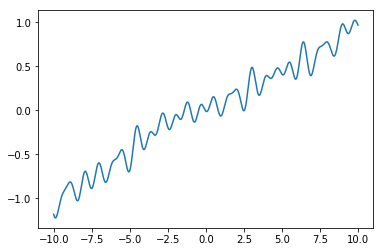

In [4]:
mesh=np.linspace(-10,10,2000)
plt.plot(mesh,[f(x) for x in mesh])
plt.show()

In [5]:
# We must pick a kernel.  
def S(x1,x2,alpha0=.1):
    return alpha0*np.exp(-2*(x1-x2)**2)

## Step I:  Determine the 'best guess' function given the kernel and observed data.

We must assume a prior mean \mu_0 function to get started.  Since our ultimate interest is in travel times and we are modeling the distance as 'x', our inital guess is \mu_0(x)=x.  

In [6]:
data_X=np.linspace(-10,10,5)
data_Y=[f(x) for x in data_X]



In [14]:

def make_matrix(data_X,S):
    matrix=np.zeros((len(data_X),len(data_X)))
    for i in range(len(data_X)):
        for j in range(len(data_X)):
            matrix[i][j]=S(data_X[i],data_X[j])
    return matrix

def mu0(x):
    return .1*x

mu0_dct={x:mu0(x) for x in mesh}

def approx(dct,data_X):
    new={}
    key_list=sorted(list(dct.keys()))
    for x in data_X:
        
        index=bisect.bisect_left(key_list,x)
#         print("#######################################",flush=True)
#         print(len(list(dct.keys())))
#         print(index)
        try:
            new[x]=(dct[key_list[index]]+dct[key_list[index+1]])/2
        except:
            new[x]=1
            
    return new


def mu(x,data_X,matrix,inv_matrix,mu0_dct):
    
#     matrix=make_matrix(data_X,S)
#     inv_matrix=np.linalg.inv(matrix)
    
    app=approx(mu0_dct,data_X)
    diff=np.array([f(y)-app[y] for y in data_X])
    sigma=np.array([S(x,y) for y in data_X])
    mat1=np.matmul(inv_matrix,diff)
    dot_prod=np.matmul(sigma,mat1)
    return dot_prod+mu0_dct[x]

def make_mumesh(mu,data_X,matrix,inv_matrix,mu0):
    return {x:mu(x,data_X,matrix,inv_matrix,mu0) for x in mesh}


def var(x,data_X,matrix,inv_matrix):
#     matrix=make_matrix(data_X,S)
#     inv_matrix=np.linalg.inv(matrix)
    sigma=np.array([S(x,y) for y in data_X])
    improvement=np.matmul(sigma,np.matmul(inv_matrix,sigma))
    return S(x,x)-improvement

def make_varmesh(var,data_X,matrix,inv_matrix):
    return {x:var(x,data_X,matrix,inv_matrix) for x in mesh}

def varx(x):
    return var(x,data_X,matrix,inv_matrix)

# def mux(x):
#     return mu(x,data_X,mu0)

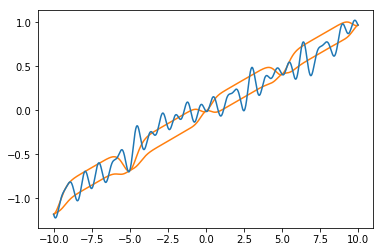

In [15]:
matrix=make_matrix(data_X,S)
inv_matrix=np.linalg.inv(matrix)

mesh=np.linspace(-10,10,2000)
plt.plot(mesh,[mu(x,data_X,matrix,inv_matrix,mu0_dct)+varx(x) for x in mesh],'C1')
plt.plot(mesh,[mu(x,data_X,matrix,inv_matrix,mu0_dct)-varx(x) for x in mesh],'C1')
plt.plot(mesh,[f(x) for x in mesh])
plt.show()

In [28]:
data_X=np.append(data_X,np.array([-7]))

In [30]:
data_X[0]

-10.0

In [42]:
def function_approximator(f,S,data_X,mu0_dct,N):
    matrix=make_matrix(data_X,S)
    inv_matrix=np.linalg.inv(matrix)
    dX=[data_X]
    data_Y=[f(x) for x in data_X]
    dY=[data_Y]
    varmesh=make_varmesh(var,data_X,matrix,inv_matrix)
    vrs=[varmesh]
    mus=[make_mumesh(mu,data_X,matrix,inv_matrix,mu0_dct)]
    
    for i in range(N):
        x_new=mesh[np.argmax([np.abs(varmesh[x]) for x in mesh])]
        data_X=np.append(data_X,np.array([x_new]))
        data_Y=np.append(data_Y,np.array([f(x_new)]))
        bla=data_X[0]

        dX.append(data_X)
        dY.append(data_Y)
        
        matrix=make_matrix(data_X,S)
        inv_matrix=np.linalg.inv(matrix)

        mu_mesh=make_mumesh(mu,data_X,matrix,inv_matrix,mu0_dct)
        varmesh=make_varmesh(var,data_X,matrix,inv_matrix)
#         print(mu_mesh)
        mus.append(mu_mesh)
        vrs.append(varmesh)

        mu0_dct=mu_mesh
        
    return mus, dX, dY, vrs


    
    
    
   

    

In [43]:
mus,dX,dY,vrs=function_approximator(f,S,data_X,mu0_dct,6)

In [44]:
def make_fun(mus):
    Xs=[]
    Ys=[]
    for i in range(len(mus)):
        x=list(mus[i].keys())
        y=[mus[i][p] for p in x]
        Xs.append(x)
        Ys.append(y)
    return Xs,Ys

In [48]:
Xs,Ys=make_fun(mus)

[]

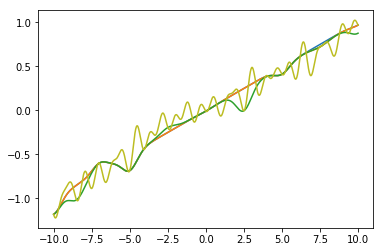

In [49]:
plt.plot(Xs[0],Ys[0],'C0')
plt.plot(Xs[1],Ys[1],'C1')
plt.plot(Xs[4],Ys[4],'C2')
plt.plot(mesh,[f(x) for x in mesh],'C8')
plt.plot()

[]

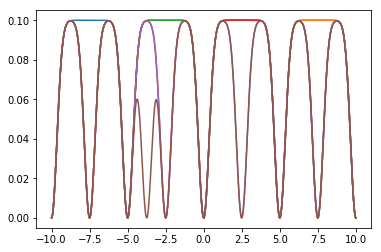

In [55]:
for i in range(len(vrs)):
    plt.plot(Xs[i],Ys[i])
# plt.plot(mesh,[f(x) for x in mesh])
plt.plot()

[]

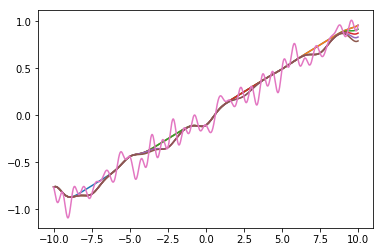

In [46]:
for i in range(len(mus)):
    plt.plot(Xs[i],Ys[i])
plt.plot(mesh,[f(x) for x in mesh])
plt.plot()

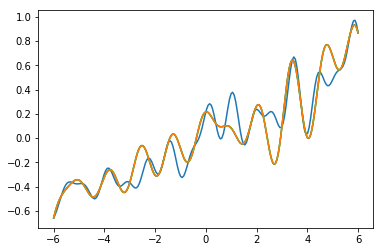

In [23]:
plt.plot(sample,[f(x) for x in sample])

plt.plot(eval_set,[mus[0](x)+vrs[0](x) for x in eval_set],'C2')
plt.plot(eval_set,[mus[0](x)-vrs[0](x) for x in eval_set],'C2')
plt.plot(sample, [mus[0](x) for x in sample])
plt.show()

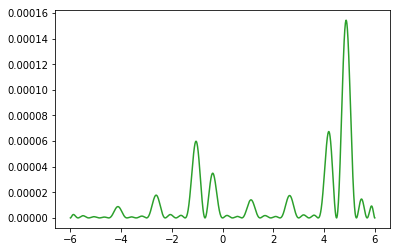

In [24]:
plt.plot(eval_set,[vrs[0](x) for x in eval_set],'C2')
plt.show()

In [ ]:
def test0(x):
    return x*2

def test(x,m):
    return m(x)*2+x*m(x)

hist=[test0]
def new(x):
    return test(x,hist[-1])

In [24]:
hist=[test0]
for i in range(10):
    def new(x):
        return test(x,hist[-1])
    hist.append(new)

In [27]:
hist[1](1)

RecursionError: maximum recursion depth exceeded